<a href="https://colab.research.google.com/github/Rhythm1821/Tensorflow-Face-Detection/blob/main/Face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Detection Tensorflow

## 1 Setup and Data gathering

### 1.1 Install dependencies

In [108]:
pip install --upgrade pip

In [109]:
pip install albumentations

In [110]:
# !pip install labelme
# import labelme

### 1.2 Collect images using opencv

In [111]:
import os, uuid,time,cv2

In [112]:
# Create data folder
if not os.path.exists('data'):
  os.mkdir('data')

# if not os.path.exists('/content/data/images'):
#   os.mkdir('/content/data/images')
# if not os.path.exists('/content/data/labels'):
#   os.mkdir('/content/data/labels')

In [113]:
"""
Take images by running this in your local to get your images
IMAGES_PATH = os.path.join('content','data','images')
number_images = 30
cap = cv2.VideoCapture(0)
for img_num in range(number_images):
  print(f'Collecting image {img_num}')
  ret, frame = cap.read()
  imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname,frame)
  cv2.imshow('frame',frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF==ord('q'):
    break

cap.release()
cv2.destroyAllWindows()]
"""

"\nTake images by running this in your local to get your images\nIMAGES_PATH = os.path.join('content','data','images')\nnumber_images = 30\ncap = cv2.VideoCapture(0)\nfor img_num in range(number_images):\n  print(f'Collecting image {img_num}')\n  ret, frame = cap.read()\n  imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')\n  cv2.imwrite(imgname,frame)\n  cv2.imshow('frame',frame)\n  time.sleep(0.5)\n\n  if cv2.waitKey(1) & 0xFF==ord('q'):\n    break\n\ncap.release()\ncv2.destroyAllWindows()]\n"

In [114]:
from zipfile import ZipFile
import requests
from pathlib import Path

data_path = Path('data/')
image_path = Path(data_path / 'images')
label_path = Path(data_path / 'labels')

if data_path.is_dir():
  print(f'{data_path} path already exists...')
else:
  print(f'Creating {data_path} path')
  data_path.mkdir(parents=True,exist_ok=True)

with open('images.zip','wb') as f:
  request = requests.get('https://github.com/Rhythm1821/Colab-Project-Data/raw/main/Face-Detection/images.zip')
  f.write(request.content)

with ZipFile('images.zip','r') as zip_ref:
  print('unzipping the data......')
  zip_ref.extractall(data_path)

with open('labels.zip','wb') as f:
  request = requests.get('https://github.com/Rhythm1821/Colab-Project-Data/raw/main/Face-Detection/labels.zip')
  f.write(request.content)

with ZipFile('labels.zip','r') as zip_ref:
  print('unzipping the data......')
  zip_ref.extractall(data_path)


data path already exists...
unzipping the data......
unzipping the data......


## 2 Review dataset and build image loading function

### 2.1 Import tf and Deps

In [115]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

In [116]:
tf.test.is_gpu_available()

False

### 2.2 Load images into a tf data pipeline

In [117]:
images = tf.data.Dataset.list_files('/content/data/images/*.jpg')

In [118]:
images.as_numpy_iterator().next()

b'/content/data/images/80d6800d-335d-11ee-9af2-7fd07a498e42.jpg'

In [119]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [120]:
images = images.map(load_image)

In [121]:
# images.as_numpy_iterator().next()

In [122]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.3 View raw images with Matplotlib

In [123]:
image_generator = images.batch(4).as_numpy_iterator() #batches images

In [124]:
plot_images = image_generator.next()

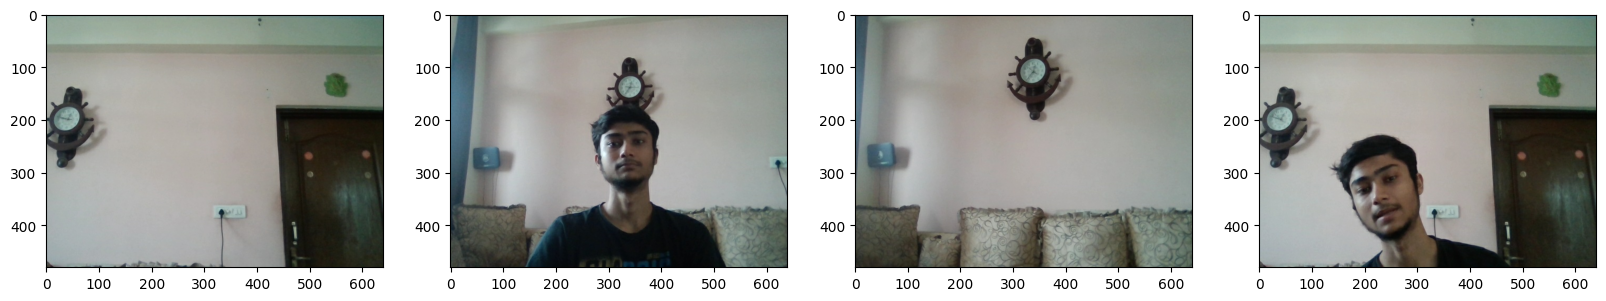

In [125]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, image in enumerate(plot_images):
  ax[idx].imshow(image)
plt.show()

In [126]:
# # os.mkdir('data')
# train_path = Path('data/train')
# train_path.mkdir()
# test_path = Path('data/test')
# test_path.mkdir()
# val_path = Path('data/val')
# val_path.mkdir()
# Path(train_path/'images').mkdir()
# Path(train_path/'labels').mkdir()
# Path(test_path/'images').mkdir()
# Path(test_path/'labels').mkdir()
# Path(val_path/'images').mkdir()
# Path(val_path/'labels').mkdir()

## 3 Partition unaugmentated data

### 3.1 Manually split data into train, test, val

In [127]:
import os
import shutil
import random
import json

data_dir = '/content/data/'
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create the train, val, and test subdirectories
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'labels'), exist_ok=True)

# Get a list of image files and label files
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'labels')

image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
label_files = [f for f in os.listdir(label_dir) if f.endswith('.json')]

# Shuffle the files while maintaining the correspondence between images and labels
random.seed(42)
random.shuffle(image_files)
random.seed(42)
random.shuffle(label_files)

# Split the data
# for images
num_images = len(image_files)
num_train = int(train_ratio * num_images)
num_val = int(val_ratio * num_images)

# for labels
num_labels = len(label_files)
num_labeltrain = int(train_ratio * num_labels)
num_labelval = int(val_ratio * num_labels)

train_image_files = image_files[:num_train]
val_image_files = image_files[num_train:num_train + num_val]
test_image_files = image_files[num_train + num_val:]

train_label_files = label_files[:num_labeltrain]
val_label_files = label_files[num_labeltrain:num_labeltrain + num_labelval]
test_label_files = label_files[num_labeltrain + num_labelval:]

# Move the images and labels to their respective folders in train, val, and test
def move_files(source_dir, dest_dir, files):
    for file in files:
        source_path = os.path.join(source_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(source_path, dest_path)

# Move images and labels to their respective folders for train, val, and test sets
move_files(image_dir, os.path.join(train_dir,'images'), train_image_files)
move_files(label_dir, os.path.join(train_dir,'labels'), train_label_files)

move_files(image_dir, os.path.join(val_dir,'images'), val_image_files)
move_files(label_dir, os.path.join(val_dir,'labels'), val_label_files)

move_files(image_dir, os.path.join(test_dir,'images'), test_image_files)
move_files(label_dir, os.path.join(test_dir,'labels'), test_label_files)

print("Data split and stored in their respective folders.")


Data split and stored in their respective folders.
